## 0. computer vision libraries

* food recognition (binary, multiclass)
* object detection

#### convolutional neural networks -> deep learning models that recognize patterns in images

 - input layer
 - convolutional layer
 https://docs.pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
 - hidden activation/non linear activation
 - pooling layer
 - output layer / linear layer
 - output activation

computer vision libraries

* torchvision
https://docs.pytorch.org/vision/stable/index.html
* torchvision.datasets
    - get datasets and data loading functions for computer vision
* torchvision.models
    - get pretrained computer vision models
* torchvision.transforms
    - functions for manipulating vision data (images) to be suitable for use with ML model -> turn imagedata into numbers
* torch.utils.data.Dataset
* torch.utils.data.DataLoader

In [1]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [2]:
# import pytorch
import torch
from torch import nn

# import torchvision
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

# import matplotlib for visulization
import matplotlib.pyplot as plt

# check version
print(torch.__version__)
print(torchvision.__version__)

2.0.0
0.15.1


## 1. getting dataset

FashionMNIST from torchvision.datasets

In [3]:
device = "cuda" if torch.cuda.is_available else "cpu"
device

'cuda'

In [4]:
# setup training data
train_data = datasets.FashionMNIST(
    root='data', # where goes the data
    train=True, # do we want the training dataset
    download=True, # do we want to download
    transform=torchvision.transforms.ToTensor(), # how to transform the data
    target_transform=None # how to transform the labels/targets
)

test_data = datasets.FashionMNIST(
    root='data',
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor(),
    target_transform=None
)



In [5]:
len(train_data), len(test_data)


(60000, 60000)

In [6]:
# see the first training example
image, label = train_data[0]
image.shape, label

(torch.Size([1, 28, 28]), 9)

In [7]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [8]:
class_to_idx = train_data.class_to_idx
class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [9]:
train_data.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

In [10]:
# check the shape
print(f"Image shape: {image.shape} -> [color channels, heigth, width]") # 1 color channel because it's black and white
print(f"Image label: {class_names[label]}")

Image shape: torch.Size([1, 28, 28]) -> [color channels, heigth, width]
Image label: Ankle boot


## 1.2 visualizing data

In [11]:
import matplotlib.pyplot as plt

image, label = train_data[0]
print(image.shape)

image.shape

torch.Size([1, 28, 28])


torch.Size([1, 28, 28])

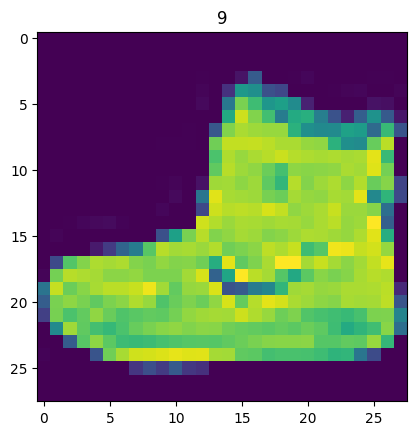

In [12]:
plt.imshow(image.squeeze());
plt.title(label);

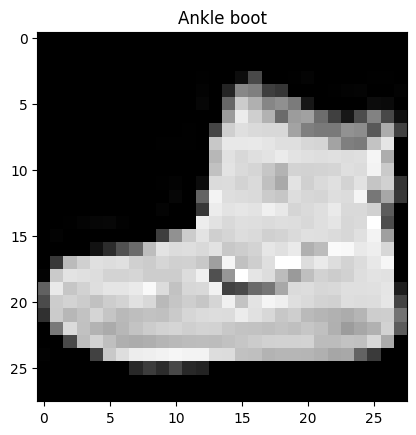

In [13]:
plt.imshow(image.squeeze(), cmap="gray")
plt.title(class_names[label]);


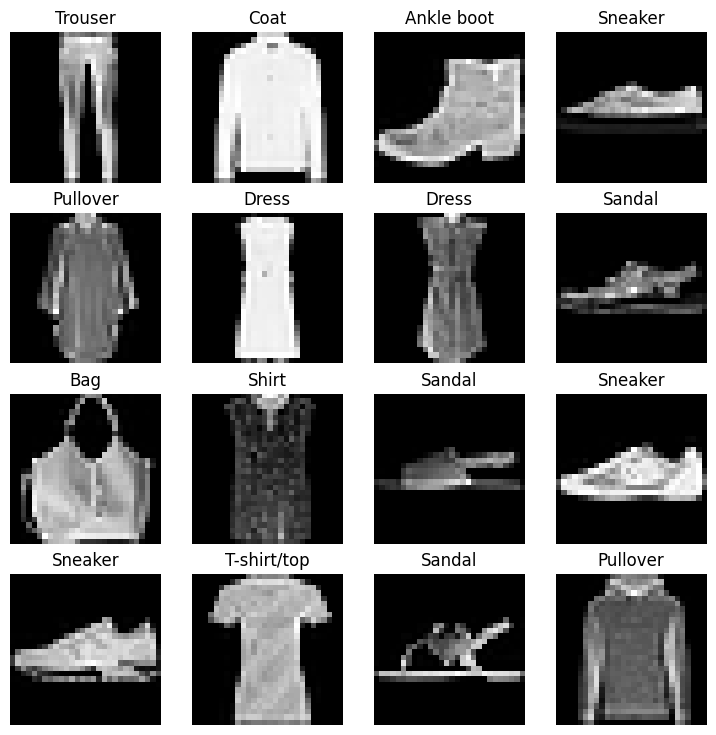

In [14]:
#torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
  random_idx = torch.randint(0, len(train_data), size=[1]).item()
  img, label = train_data[random_idx]
  ax = fig.add_subplot(rows, cols, i)
  ax.imshow(img.squeeze(), cmap='gray')
  ax.set_title(class_names[label])
  ax.axis("off")



In [15]:
train_data, test_data

(Dataset FashionMNIST
     Number of datapoints: 60000
     Root location: data
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset FashionMNIST
     Number of datapoints: 60000
     Root location: data
     Split: Train
     StandardTransform
 Transform: ToTensor())

## 2. prepare dataloader

at the moment - data in form pytorch datasets

dataloader turns data into python iterable

want to turn data into batches

 - more comutationally efficient
 - break down to 32 images at a time rather than looking at 60000 images at a time
 - gives the neural network more chance to update gradient per epoch, updates weights every 32 images

In [16]:
from torch.utils.data import DataLoader
BATCH_SIZE = 32
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

https://docs.pytorch.org/tutorials/beginner/basics/data_tutorial.html

In [17]:
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x16e673010>,
 <torch.utils.data.dataloader.DataLoader at 0x16e272290>)

In [18]:
print(f"DataLoader: {train_dataloader, test_dataloader}")
print(f"Length of train Data Loasder: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test Data Loasder: {len(test_dataloader)} batches of {BATCH_SIZE}")

DataLoader: (<torch.utils.data.dataloader.DataLoader object at 0x16e673010>, <torch.utils.data.dataloader.DataLoader object at 0x16e272290>)
Length of train Data Loasder: 1875 batches of 32
Length of test Data Loasder: 1875 batches of 32


In [19]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

Image Size: torch.Size([1, 28, 28])
Label: 4, label size: torch.Size([])


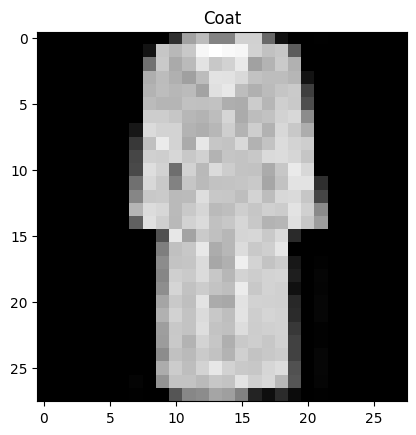

In [20]:
torch.manual_seed(42)
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap='gray')
plt.title(class_names[label])
print(f"Image Size: {img.shape}")
print(f"Label: {label}, label size: {label.shape}")

## 3. Model 0: base line model

baseline model simple to start with gives room for adding complexity when necessary
https://docs.pytorch.org/docs/stable/generated/torch.nn.Flatten.html

In [21]:
# cerate a flatten layer
flatten_model = nn.Flatten()

# get a single sample
x = train_features_batch[0]

# flatten the sample
x_flat = flatten_model(x)

# print out
print(f"Shape before flattening: {x.shape} -> [color channel, weight, height]")
print(f"Shape after flattening: {x_flat.shape} -> [color channel, weight * height]")

Shape before flattening: torch.Size([1, 28, 28]) -> [color channel, weight, height]
Shape after flattening: torch.Size([1, 784]) -> [color channel, weight * height]


In [22]:
from torch import nn
class FashionMNISTModelV0(nn.Module):
  def __init__(self, input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape,
                  out_features=hidden_units),
        nn.Linear(in_features=hidden_units,
                  out_features=output_shape)
    )
  def forward(self, x):
    return self.layer_stack(x)

In [23]:
torch.manual_seed(42)
# set up model with input parameters

model_0 = FashionMNISTModelV0(
    input_shape=784, # output of flatten must be the input shape of linear, after flattening we get 28 * 28
    hidden_units=10, # units in the hidden layer
    output_shape=len(class_names) # one for every class
).to('cpu')

model_0

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [24]:
dummy_x = torch.rand([1, 1, 28, 28])
model_0(dummy_x).shape

torch.Size([1, 10])

In [25]:
model_0.state_dict()

OrderedDict([('layer_stack.1.weight',
              tensor([[ 0.0273,  0.0296, -0.0084,  ..., -0.0142,  0.0093,  0.0135],
                      [-0.0188, -0.0354,  0.0187,  ..., -0.0106, -0.0001,  0.0115],
                      [-0.0008,  0.0017,  0.0045,  ..., -0.0127, -0.0188,  0.0059],
                      ...,
                      [-0.0116,  0.0273, -0.0344,  ...,  0.0176,  0.0283, -0.0011],
                      [-0.0230,  0.0257,  0.0291,  ..., -0.0187, -0.0087,  0.0001],
                      [ 0.0176, -0.0147,  0.0053,  ..., -0.0336, -0.0221,  0.0205]])),
             ('layer_stack.1.bias',
              tensor([-0.0093,  0.0283, -0.0033,  0.0255,  0.0017,  0.0037, -0.0302, -0.0123,
                       0.0018,  0.0163])),
             ('layer_stack.2.weight',
              tensor([[ 0.0614, -0.0687,  0.0021,  0.2718,  0.2109,  0.1079, -0.2279, -0.1063,
                        0.2019,  0.2847],
                      [-0.1495,  0.1344, -0.0740,  0.2006, -0.0475, -0.2514, -0.

## 3.1 setup loss optimizer and evaluation metrics

* loss function nn.CrossEntropyLoss
* optimizer torch.optim.SGD stochastic gradient descent
* evaluation metric

In [26]:
import requests
from pathlib import Path

# download helper function from pytorch repo
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

helper_functions.py already exists, skipping download


In [27]:
# import the accuracy metric from helper functions
from helper_functions import accuracy_fn

# setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

## 3.2 creating function to time experiments

* track models performance
* track how fast the model runs

In [28]:
from timeit import default_timer as timer
def print_train_time(start: float,
                     end: float,
                     device: torch.device = None):
  """prints diffetrence between start and end time"""
  total_time = end - start
  print(f"Train time on {device}: {total_time:.3f} seconds")
  return total_time

In [29]:
start_time = timer()

end_time = timer()

print_train_time(start=start_time, end=end_time, device='cpu')

Train time on cpu: 0.000 seconds


1.3749988283962011e-05

### 3.3 creating a training and training a model on batches of data

1. loop through number of epochs
2. loop through training batches, perform training steps, calculate the training loss *per batch*
3. loop through testing batches, perform testing steps, calculate the test loss per batch
4. printing
5. time it

In [30]:
# import tqdm for progress bar
from tqdm.auto import tqdm

# set the seed and start the timer
torch.manual_seed(42)
train_time_start_on_cpu = timer()

# set the number of epochs
epochs = 3

# creating training and test loop
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n------")

  ### training
  train_loss = 0

  # add a loop to loop through the traing batches
  for batch, (X, y) in enumerate(train_dataloader):
    model_0.train()

    # 1. forward
    y_pred = model_0(X)

    # 2. calculate loss per batch
    loss = loss_fn(y_pred, y)
    train_loss += loss # accumulate the train loss

    # 3 optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. optimizer step
    optimizer.step()

    # printing out
    if batch % 400 == 0:
      print(f"seen {batch * len(X)}/{len(train_dataloader.dataset)} samples.")

      # divide total train by length of train dataloader
  train_loss/= len(train_dataloader)

  ### testing
  test_loss, test_acc = 0, 0
  model_0.eval()
  with torch.inference_mode():
    for X_test, y_test in test_dataloader:
      # 1. forward pass
      test_pred = model_0(X_test)

      # 2. calculate the loss
      test_loss += loss_fn(test_pred, y_test)

      # 3. calculate accuracy
      test_acc += accuracy_fn(y_true=y_test, y_pred=test_pred.argmax(dim=1))

    # calculate the test loss average per batch
    test_loss /= len(test_dataloader)

    # calculate the test acc average per batchg
    test_acc /= len(test_dataloader)

  print(f"\nTrain loss {train_loss:.4f} | Test loss {test_loss:.4f} | Test acc {test_acc:.4f}")

# calculate the train time
train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(start=train_time_start_on_cpu,
                                            end=train_time_end_on_cpu,
                                            device=str(next(model_0.parameters()).device))



/Users/marcelmann/miniconda-x86_64/envs/pytorch-course/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
------
seen 0/60000 samples.
seen 12800/60000 samples.
seen 25600/60000 samples.
seen 38400/60000 samples.
seen 51200/60000 samples.


 33%|███▎      | 1/3 [00:05<00:10,  5.35s/it]


Train loss 0.5904 | Test loss 0.4743 | Test acc 83.3100
Epoch: 1
------
seen 0/60000 samples.
seen 12800/60000 samples.
seen 25600/60000 samples.
seen 38400/60000 samples.
seen 51200/60000 samples.


 67%|██████▋   | 2/3 [00:10<00:05,  5.04s/it]


Train loss 0.4763 | Test loss 0.4395 | Test acc 84.6333
Epoch: 2
------
seen 0/60000 samples.
seen 12800/60000 samples.
seen 25600/60000 samples.
seen 38400/60000 samples.
seen 51200/60000 samples.


100%|██████████| 3/3 [00:15<00:00,  5.04s/it]


Train loss 0.4550 | Test loss 0.4303 | Test acc 84.9417
Train time on cpu: 15.149 seconds


In [31]:
str(next(model_0.parameters()).device)

'cpu'

## 4. make predictions get Model 0 result

In [32]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn):
  """returns a dict containing results of model predicting on data loader"""

  loss, acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X, y in tqdm(data_loader):
      # make predictions
      y_pred = model(X)

      # accumulate the loss and acc values per batch
      loss += loss_fn(y_pred, y)
      acc += accuracy_fn(y_true=y,
                         y_pred=y_pred.argmax(dim=1))

    # scale loss and acc to find avg loss/acc per batch
    loss /= len(data_loader)
    acc /= len(data_loader)

    return {"model_name": model.__class__.__name__,
            "model_loss": loss.item(),
            "model_acc": acc}

# calculate model 0 res on the test data
model_0_results = eval_model(model=model_0,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn)
model_0_results

100%|██████████| 1875/1875 [00:02<00:00, 826.07it/s]


{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.4302612543106079,
 'model_acc': 84.94166666666666}

##5. setup device agnostic code

In [33]:
import torch
device = "cuda" if torch.cuda.is_available else "cpu"
device

'cuda'

## 6 building a model with non-linearity

In [34]:
class FashionMNISTModelV1(nn.Module):
  def __init__(self, input_shape, hidden_units, output_shape):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape,
                  out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units,
                  out_features=output_shape),
        nn.ReLU()
    )
  def forward(self, x):
    return self.layer_stack(x)

In [35]:
torch.manual_seed(42)
model_1 = FashionMNISTModelV1(input_shape=784,
                              hidden_units=10,
                              output_shape=len(class_names))#.to(device)
next(model_1.parameters()).device

device(type='cpu')

## 6.1 loss optimizer evaluation metrics

In [36]:
from helper_functions import accuracy_fn
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(),
                              lr=0.1)

## 6.2 functionizing training and testing loop

In [37]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device=device):

  train_loss, train_acc = 0, 0

  # put model into training mode
  model.train()

  # add a loop to loop through the training batches
  for batch, (X, y) in enumerate(data_loader):

    # put data on device
    X, y = X.to(device), y.to(device)

    # 1. forward pass (output raw logits from the model)
    y_pred = model(X)

    # 2. calculate loss and accuracy per batch
    loss = loss_fn(y_pred, y)
    train_loss += loss # accumulate train loss
    train_acc += accuracy_fn(y_true=y,
                             y_pred=y_pred.argmax(dim=1))

    # 3. optimizer zero grad
    optimizer.zero_grad()

    # 4 loss backward
    loss.backward()

    # optimizer step
    optimizer.step()

  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f"Train loss: {train_loss:.5f} | Train acc: {train_acc:.2f}%")


In [38]:
def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):

  ### testing
  test_loss, test_acc = 0, 0
  model.eval()

  with torch.inference_mode():

    for X, y in data_loader:

      X, y = X.to(device), y.to(device)

      # 1. forward pass
      test_pred = model(X)

      # 2. calculate the loss
      test_loss += loss_fn(test_pred, y)

      # 3. calculate accuracy
      test_acc += accuracy_fn(y_true=y,
                              y_pred=test_pred.argmax(dim=1))

    # calculate the test loss average per batch
    test_loss /= len(data_loader)

    # calculate the test acc average per batchg
    test_acc /= len(data_loader)

  print(f"\nTest loss {train_loss:.4f} | Test acc {test_acc:.2f}%\n")



In [39]:
torch.manual_seed(42)

# Measure time
from timeit import default_timer as timer
train_time_start_on_gpu = timer()

# set epochs
epochs = 3

# create a optimization and evaluation loop using train_step() and test_step()
for epoch in range(epochs):
  print(f"Epoch: {epoch}\n-----")
  train_step(model=model_1,
               data_loader=train_dataloader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=accuracy_fn,
               device=None)

  test_step(model=model_1,
              data_loader=test_dataloader,
              loss_fn=loss_fn,
              accuracy_fn=accuracy_fn,
              device=None)

  train_time_end_on_gpu = timer()
  total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,
                                              end=train_time_end_on_gpu,
                                              device=device)

Epoch: 0
-----
Train loss: 1.09199 | Train acc: 61.34%

Test loss 0.4550 | Test acc 66.00%

Train time on cuda: 4.959 seconds
Epoch: 1
-----
Train loss: 0.78101 | Train acc: 71.93%

Test loss 0.4550 | Test acc 75.19%

Train time on cuda: 10.022 seconds
Epoch: 2
-----
Train loss: 0.67027 | Train acc: 75.94%

Test loss 0.4550 | Test acc 76.43%

Train time on cuda: 15.507 seconds


In [40]:
model_1_results = eval_model(model=model_1,
                            data_loader=test_dataloader,
                            loss_fn=loss_fn,
                            accuracy_fn=accuracy_fn)
model_1_results

100%|██████████| 1875/1875 [00:02<00:00, 820.67it/s]


{'model_name': 'FashionMNISTModelV1',
 'model_loss': 0.6430193781852722,
 'model_acc': 76.42833333333333}

## Model 2: Building a Convolutional Neural Network (CNN)

also known as ConvNets

capable of finding pattern in in visual data

https://poloclub.github.io/cnn-explainer/
https://viso.ai/deep-learning/vgg-very-deep-convolutional-networks/

In [41]:
# create a convolutional neural network
class FashionMNISTModelV2(nn.Module):
  """Model architecture that replicates TinyVGG Model from CNN explainer website"""
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        # 1st conv layer https://poloclub.github.io/cnn-explainer/
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),

        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
        # 2rd conv layer https://poloclub.github.io/cnn-explainer/
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),

        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
        # output layer
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*7*7,
                  out_features=output_shape)
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    #print(f"Output shape of conv_block_1: {x.shape}")
    x = self.conv_block_2(x)
    #print(f"Output shape of conv_block_2: {x.shape}")
    x = self.classifier(x)
    #print(f"Output shape of classifier: {x.shape}")
    return x

In [42]:
torch.manual_seed(42)
model_2 = FashionMNISTModelV2(input_shape=1, # one color channel for black and white images
                              hidden_units=10,
                              output_shape=len(class_names))

In [43]:
rand_tensor = torch.randn(size=(1, 28, 28))
rand_tensor.shape

torch.Size([1, 28, 28])

In [44]:
model_2(rand_tensor.unsqueeze(0))

[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


tensor([[ 0.0366, -0.0940,  0.0686, -0.0485,  0.0068,  0.0290,  0.0132,  0.0084,
         -0.0030, -0.0185]], grad_fn=<AddmmBackward0>)

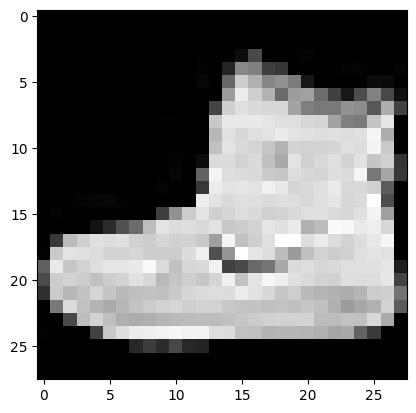

In [45]:
plt.imshow(image.squeeze(), cmap='gray');

In [46]:
image.shape

torch.Size([1, 28, 28])

### 7.1 step through nn.Conv2d

https://docs.pytorch.org/docs/stable/generated/torch.nn.Conv2d.html

In [47]:
torch.manual_seed(42)

# create a batch of images
images = torch.randn(size=(32, 3, 64, 64))
test_image = images[0]

print(f"Image batch shape: {images.shape}")
print(f"Single image shape: {test_image.shape}")
print(f"Test image:\n {test_image}")

Image batch shape: torch.Size([32, 3, 64, 64])
Single image shape: torch.Size([3, 64, 64])
Test image:
 tensor([[[ 1.9269,  1.4873,  0.9007,  ...,  1.8446, -1.1845,  1.3835],
         [ 1.4451,  0.8564,  2.2181,  ...,  0.3399,  0.7200,  0.4114],
         [ 1.9312,  1.0119, -1.4364,  ..., -0.5558,  0.7043,  0.7099],
         ...,
         [-0.5610, -0.4830,  0.4770,  ..., -0.2713, -0.9537, -0.6737],
         [ 0.3076, -0.1277,  0.0366,  ..., -2.0060,  0.2824, -0.8111],
         [-1.5486,  0.0485, -0.7712,  ..., -0.1403,  0.9416, -0.0118]],

        [[-0.5197,  1.8524,  1.8365,  ...,  0.8935, -1.5114, -0.8515],
         [ 2.0818,  1.0677, -1.4277,  ...,  1.6612, -2.6223, -0.4319],
         [-0.1010, -0.4388, -1.9775,  ...,  0.2106,  0.2536, -0.7318],
         ...,
         [ 0.2779,  0.7342, -0.3736,  ..., -0.4601,  0.1815,  0.1850],
         [ 0.7205, -0.2833,  0.0937,  ..., -0.1002, -2.3609,  2.2465],
         [-1.3242, -0.1973,  0.2920,  ...,  0.5409,  0.6940,  1.8563]],

        [[-0

In [48]:
test_image.shape

torch.Size([3, 64, 64])

In [49]:
torch.manual_seed(42)
# create a single conv2d layer
conv_layer = nn.Conv2d(in_channels=3,
                       out_channels=10,
                       kernel_size=3,
                       stride=1,
                       padding=0)
# pass the data through the convolutional layer
conv_output = conv_layer(test_image.unsqueeze(0))
conv_output.shape

torch.Size([1, 10, 62, 62])

## 7.2 stepping through nn.MaxPool2d

https://docs.pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html

In [50]:
test_image.shape

torch.Size([3, 64, 64])

In [51]:
# print out original image shape without unsqueezed dimension
print(f"Test image original shape: {test_image.shape}")
print(f"Test image without unsqueezed dimensions: {test_image.unsqueeze(0).shape}")

# create a sample nn.MaxPool2d layer
max_pool_layer = nn.MaxPool2d(kernel_size=2)

# pass data through conv layer
test_image_through_conv = conv_layer(test_image.unsqueeze(dim=0))
print(f"Shape after going through conv layer: {test_image_through_conv.shape}")

# pass data through conv and max pool
test_image_through_conv_and_max_pool = max_pool_layer(test_image_through_conv)
print(f"Shape after going rthrough conv and max pool layers: {test_image_through_conv_and_max_pool.shape} ")

Test image original shape: torch.Size([3, 64, 64])
Test image without unsqueezed dimensions: torch.Size([1, 3, 64, 64])
Shape after going through conv layer: torch.Size([1, 10, 62, 62])
Shape after going rthrough conv and max pool layers: torch.Size([1, 10, 31, 31]) 


In [52]:
torch.manual_seed(42)
# create random tensor
random_tensor = torch.randn(size=(1, 1, 2, 2))
print(f"\nTensor before going through max pool: \n{random_tensor}\n {random_tensor.shape}")
# create max pool
max_pool_layer = nn.MaxPool2d(kernel_size=2)

# pass the random tensor through the max pool layer
random_tensor_through_max_pool = max_pool_layer(random_tensor)
print(f"\nTensor after going through max pool: \n{random_tensor_through_max_pool}\n {random_tensor_through_max_pool.shape}")


Tensor before going through max pool: 
tensor([[[[0.3367, 0.1288],
          [0.2345, 0.2303]]]])
 torch.Size([1, 1, 2, 2])

Tensor after going through max pool: 
tensor([[[[0.3367]]]])
 torch.Size([1, 1, 1, 1])


## 7.3 setup loss function and optimizer for model_2

In [53]:
# setup loss function/eval metrics/optimizer
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr=0.1)

## 7.4 training and testing model 2

In [54]:
torch.manual_seed(42)
# measure the time
from timeit import default_timer as timer
train_time_start_model_2 = timer()

epochs = 3

for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch} -----")
  train_step(model=model_2,
             data_loader=train_dataloader,
             loss_fn=loss_fn,
             optimizer=optimizer,
             accuracy_fn=accuracy_fn,
             device=None)

  test_step(model=model_2,
            data_loader=test_dataloader,
            loss_fn=loss_fn,
            accuracy_fn=accuracy_fn,
            device=None)
  train_time_end_model_2 = timer()
  total_train_time_model_2 = print_train_time(start=train_time_start_model_2,
                                              end=train_time_end_model_2,
                                              device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0 -----
Train loss: 0.59391 | Train acc: 78.26%


 33%|███▎      | 1/3 [00:50<01:40, 50.29s/it]


Test loss 0.4550 | Test acc 86.50%

Train time on cuda: 50.293 seconds
Epoch: 1 -----
Train loss: 0.35911 | Train acc: 86.96%


 67%|██████▋   | 2/3 [01:40<00:50, 50.05s/it]


Test loss 0.4550 | Test acc 87.36%

Train time on cuda: 100.169 seconds
Epoch: 2 -----
Train loss: 0.32115 | Train acc: 88.34%


100%|██████████| 3/3 [02:29<00:00, 49.91s/it]


Test loss 0.4550 | Test acc 89.57%

Train time on cuda: 149.746 seconds


In [55]:
model_2_results = eval_model(model=model_2,
                            data_loader=test_dataloader,
                            loss_fn=loss_fn,
                            accuracy_fn=accuracy_fn)
model_2_results

100%|██████████| 1875/1875 [00:13<00:00, 142.66it/s]


{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.2881324589252472,
 'model_acc': 89.57}

#8. Compare model results and training time

In [56]:
import pandas as pd
compare_models = pd.DataFrame([model_0_results,
                               model_1_results,
                               model_2_results])
compare_models

,model_name,model_loss,model_acc
0,FashionMNISTModelV0,0.430261,84.941667
1,FashionMNISTModelV1,0.643019,76.428333
2,FashionMNISTModelV2,0.288132,89.570000


In [57]:
# add training time to results
compare_models["traing_time"] = [total_train_time_model_0,
                                 total_train_time_model_1,
                                 total_train_time_model_2]
compare_models

,model_name,model_loss,model_acc,traing_time
0,FashionMNISTModelV0,0.430261,84.941667,15.148577
1,FashionMNISTModelV1,0.643019,76.428333,15.506539
2,FashionMNISTModelV2,0.288132,89.570000,149.745774


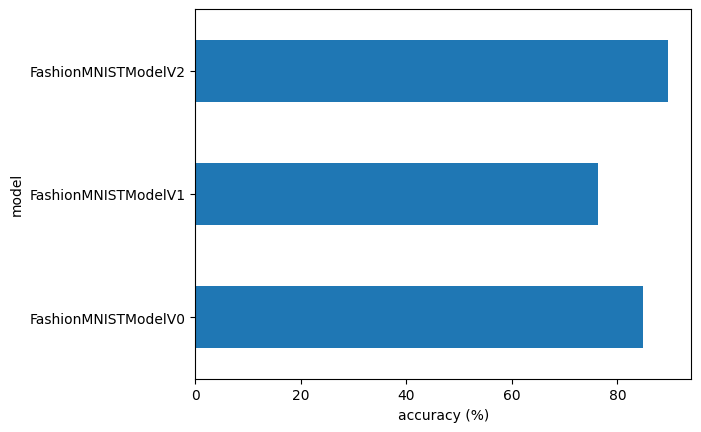

In [58]:
# visualize model results
compare_models.set_index("model_name")["model_acc"].plot(kind="barh") # barh -> horizontal bar chart
plt.xlabel("accuracy (%)")
plt.ylabel("model");

## 9. make and evaluate random predictions with best performing model

In [59]:
def make_predictions(model: torch.nn.Module,
                     data: list,
                     device=None):

  pred_probs = []
  model.eval()
  with torch.inference_mode():
    for sample in data:
      # prepare the data sample (add batch dimension and pass to target device)
      sample = torch.unsqueeze(sample, dim=0).to(device)

      # forward pass (model outputs raw logits)
      pred_logit = model(sample)

      # get prediction probability (logit -> prediction probability)
      pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

      # get pred_prob off the gpu for further calculations
      pred_probs.append(pred_prob.cpu())
  # stack the pred_probs to turn list into tensor
  return torch.stack(pred_probs)

In [60]:
img, labels = test_data[0][:10]
img.shape, labels

(torch.Size([1, 28, 28]), 9)

In [61]:
import random
#random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
  test_samples.append(sample)
  test_labels.append(label)

# view first sample shape
test_samples[0].shape

torch.Size([1, 28, 28])

Text(0.5, 1.0, 'Dress')

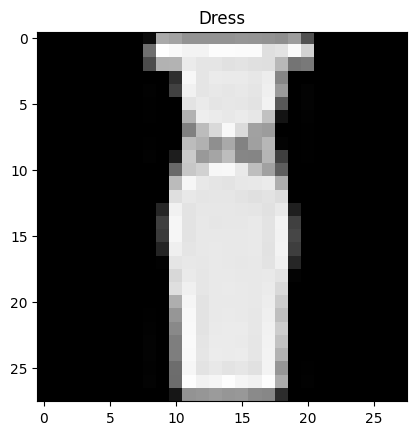

In [62]:
plt.imshow(test_samples[0].squeeze(), cmap="gray")
plt.title(class_names[test_labels[0]])

In [63]:
# make predictions
pred_probs = make_predictions(model=model_2,
                              data=test_samples)
# view first two probablities
pred_probs[:2]

tensor([[1.2889e-04, 6.6617e-04, 3.5123e-06, 9.9862e-01, 3.8668e-04, 1.9404e-06,
         2.8220e-05, 1.0975e-04, 2.0730e-05, 3.3907e-05],
        [4.5613e-04, 4.4879e-06, 1.1074e-01, 9.6504e-05, 7.8500e-01, 5.1826e-06,
         1.0014e-01, 7.1376e-06, 3.5476e-03, 4.8393e-06]])

In [64]:
# convert prediction probabilities to labels

In [65]:
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([3, 4, 2, 5, 2, 5, 0, 7, 3])

In [66]:
test_labels

[3, 4, 2, 5, 2, 5, 0, 7, 3]

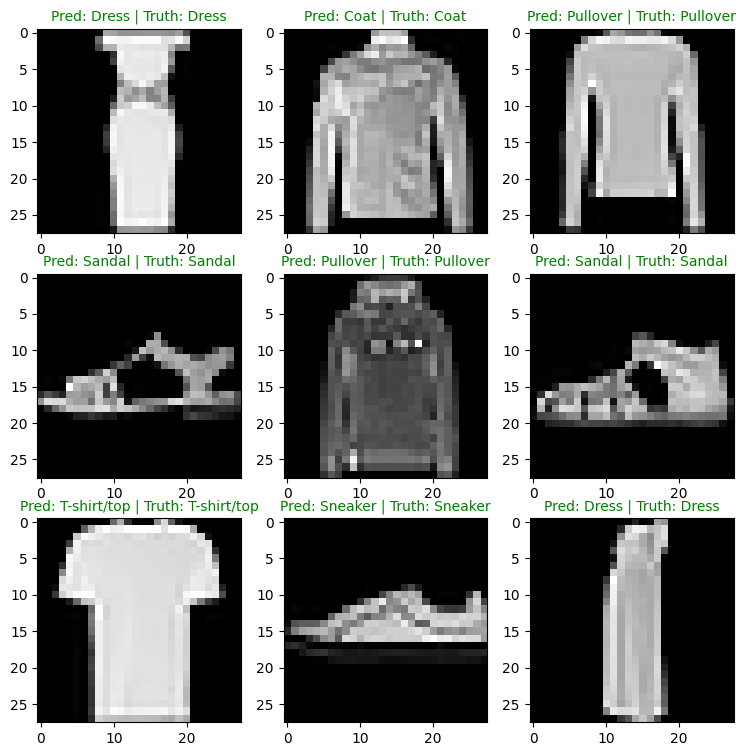

In [67]:
# plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  plt.subplot(nrows, ncols, i+1)

  # plot the target image
  plt.imshow(sample.squeeze(), cmap="gray")

  # find the prediction (in text form, e.g "sandal")
  pred_label = class_names[pred_classes[i]]

  # get the truth label
  truth_label = class_names[test_labels[i]]

  # create a title for the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"

  # check for equality between pred and truth and change color of title text
  if pred_label == truth_label:
    plt.title(title_text, fontsize=10, c="g")
  else:
    plt.title(title_text, fontsize=10, c="r")

## 10. making a confusio matrix for further predictions

way of evaluating classification model visually

https://lightning.ai/docs/torchmetrics/stable/classification/confusion_matrix.html

1. make predictions with trained model on the test data
2. make confusion matrix `trochmetrics.ConfusionMatrix`
https://rasbt.github.io/mlxtend/user_guide/evaluate/confusion_matrix/

3. plot the confusion matrix `mlxtend.plotting.plot_confusion_matrix()`

https://rasbt.github.io/mlxtend/user_guide/plotting/plot_confusion_matrix/


In [68]:
# import tqdm.auto
from tqdm.auto import tqdm

# make predictions with trained model
y_preds = []
model_2.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions..."):

    # send the data and targets to target device
    # X, y = X.to(device), y.to(device)

    # do the forward pass
    y_logit = model_2(X)

    # turn predictions from logits -> prediction probabilities -> prediction labels
    y_pred = torch.softmax(y_logit.squeeze(), dim=0).argmax(dim=1)

    # put prediction on cpu for evaluation
    y_preds.append(y_pred.cpu())

  # concatenate list of predictions into tensor
  #print(y_preds)
  y_pred_tensor = torch.cat(y_preds)
  y_pred_tensor[:10]


Making predictions...: 100%|██████████| 1875/1875 [00:12<00:00, 146.59it/s]


In [69]:
len(y_pred_tensor)

60000

In [70]:
try:
  import mlxtend, torchmetrics
  print(f"mlxtend version: {mlxtend.__version__}")
  assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend version should be 0.19.0 ofr higher"
except:
  !pip install -q torchmetrics -U mlxtend
  import torchmetrics, mlxtend
  print(f"mlxtend version: {mlxtend.__version__}")

mlxtend version: 0.23.4


In [71]:
import mlxtend
print(mlxtend.__version__)

0.23.4


tensor([[3827,   41,  219,  400,   38,    0, 1438,    1,   36,    0],
        [  22, 5590,   33,  250,   64,    0,   33,    1,    7,    0],
        [  25,   17, 4934,   60,  567,    1,  381,    0,   15,    0],
        [ 116,  126,   99, 5171,  285,    0,  181,    0,   21,    1],
        [  10,   31,  547,  232, 4707,    0,  456,    0,   17,    0],
        [  16,   41,   16,   44,    4, 5110,   18,  391,  246,  114],
        [ 353,   40,  630,  239,  553,    3, 4149,    0,   33,    0],
        [   0,   16,    1,    0,    2,  171,    0, 5485,   70,  255],
        [  54,   17,  124,  105,   93,   24,  178,   24, 5378,    3],
        [   3,   10,    4,    7,    7,  131,    6,  440,   84, 5308]])


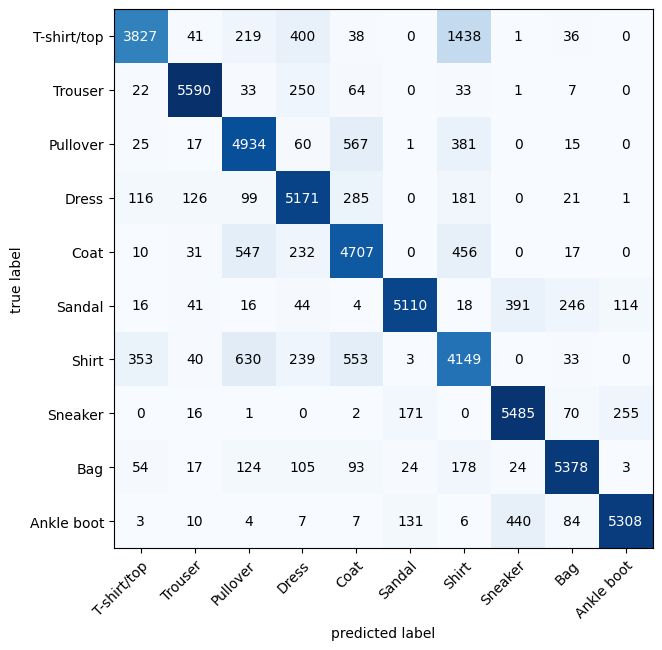

In [72]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. setup confusion instance and compare predictions to targets
confmat = ConfusionMatrix(task='multiclass',
                          num_classes=len(class_names))
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_data.targets)

print(confmat_tensor)

# 3. plt the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_names,
    figsize=(10, 7)
)

In [73]:
## 11. save and load model

from pathlib import Path
import torch

MODEL_PATH = Path("best_model")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "03_pytorch_model_2.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_2.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: best_model/03_pytorch_model_2.pth


In [74]:
# create new instance
torch.manual_seed(42)

loaded_model_2 = FashionMNISTModelV2(input_shape=1,
                                     hidden_units=10,
                                     output_shape=len(class_names))

# load in the saved state dict()
loaded_model_2.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

# send the model to the target device
loaded_model_2#.to(device)

FashionMNISTModelV2(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [75]:
model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.2881324589252472,
 'model_acc': 89.57}

In [76]:
# evaluate loaded model
torch.manual_seed(42)

loaded_model_2_results = eval_model(
    model=loaded_model_2,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn
)
loaded_model_2_results

100%|██████████| 1875/1875 [00:13<00:00, 135.98it/s]


{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.2881324589252472,
 'model_acc': 89.57}

In [77]:
# check if model results are close to each other
torch.isclose(torch.tensor(model_2_results["model_loss"]),
              torch.tensor(loaded_model_2_results["model_loss"]),
              atol=1e-02) # absolute tolerance

tensor(True)